In [4]:
import os

import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle
import json
import scipy.stats as sp
import matplotlib.colors as mcolors


%matplotlib inline

In [5]:
filelocation="data/"
filename="201603.as-rel-geo.txt"

filepath=filelocation+filename

In [6]:
edge_list = pd.read_csv(filepath, sep='|', usecols=[0,1], header=None, names=["source", "target"])

# edge_list.describe()
# edge_list.head

print(edge_list.iloc[:5])

FileNotFoundError: [Errno 2] File b'data/201603.as-rel-geo.txt' does not exist: b'data/201603.as-rel-geo.txt'

In [7]:
# test_list = edge_list.head(1000)
# G = nx.from_pandas_edgelist(test_list)
# nx.draw(G)

In [8]:
G = nx.from_pandas_edgelist(edge_list)

graph_nodes = G.__len__()
graph_edges = G.size()

# Number of nodes
print("Number of nodes in graph: \n\t", graph_nodes)
# Number of edges
print("Number of edges in graph: \n\t", graph_edges)

NameError: name 'edge_list' is not defined

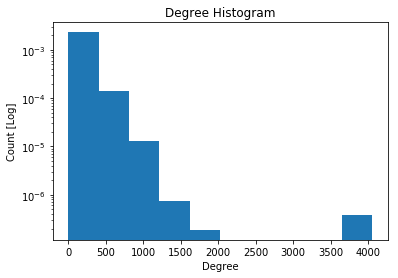

In [6]:
degrees = list(dict(G.degree()).values())

plt.title("Degree Histogram")
plt.ylabel("Count [Log]")
plt.xlabel("Degree")
plt.hist(degrees, density=True, log=True)
plt.show()

In [7]:
# Show 10 highest degrees
print(sorted(degrees)[::-1][:10])
# Show 10 lowest degrees
print(sorted(degrees)[:10])

[4056, 3733, 1707, 1465, 1364, 1250, 1242, 1215, 1191, 1184]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [8]:
# # Select where the degree is highest
# # index_highest_degree = int(np.argwhere(degrees==np.max(degrees))[0])
# name_highest_sourcedegree = edge_list['source'].value_counts()[:1].index[0]


# # Show n highest out-degree nodes
# node_sample_size = 500
# test = [edge_list['source'].value_counts()[n:].index[0] for n in range(0,node_sample_size)]
# # print(test)

# # edge_list.loc[edge_list['source'] == name_highest_sourcedegree]
# size_subgraph = edge_list.loc[edge_list['source'].isin(test)].shape

# print(size_subgraph[0]/graph_edges)

In [9]:
node_sample_sizes = [10, 50, 100, 500, 1000, 2500]
frac_list = []

for s in node_sample_sizes:
    degree_loc = [edge_list['source'].value_counts()[n:].index[0] for n in range(0,s)]
    size_subgraph = edge_list.loc[edge_list['source'].isin(degree_loc)].shape[0]
    fraction = size_subgraph / graph_edges
    frac_list.append(fraction)

In [10]:
print(frac_list)

[0.051651230296906075, 0.14880059728774722, 0.2464713037993422, 0.7078439070857121, 0.9569283447792031, 0.9941140124477856]


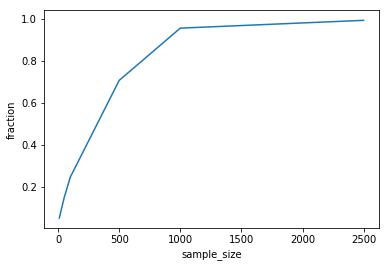

In [11]:
df_frac = pd.DataFrame(list(zip(node_sample_sizes, frac_list)),columns=['sample_size','fraction'])
ax = sns.lineplot(x='sample_size', y='fraction', data=df_frac)

In [12]:
r=nx.degree_assortativity_coefficient(G)
print(r)

-0.20526813827233995


In [13]:
# rich_club = nx.rich_club_coefficient(G)
# sorted_rich_club = sorted(rich_club, key=rich_club.get)
# print(sorted_rich_club)

In [14]:
# Select the largest connected component

connected_components = nx.connected_components(G)
largest_cc = max(connected_components, key=len)
G2 = G.subgraph(largest_cc)
print(len(G2))


# component_list = [len(n) for n in connected_components]
# print(np.max(sorted(component_list)))
# print(component_list)
# print(sorted(component_list)[::-1][:5])

11921


In [15]:
graph_nodes = G2.__len__()
graph_edges = G2.size()

# Number of nodes
print("Number of nodes in graph: \n\t", graph_nodes)
# Number of edges
print("Number of edges in graph: \n\t", graph_edges)

Number of nodes in graph: 
	 11921
Number of edges in graph: 
	 310014


In [16]:
metrics = {
    'degree_centrality': lambda g: nx.degree_centrality(g),
    'eigenvector_centrality': lambda g: nx.eigenvector_centrality(g),
#     'katz_centrality': lambda g: nx.katz_centrality(g),
#     'closeness': lambda g: nx.closeness_centrality(g),
#     'load_centrality': lambda g: nx.load_centrality(g),
#     'harmonic_centrality': lambda g: nx.harmonic_centrality(g),
#     'pagerank': lambda g: nx.pagerank(g),
    'clustering_coeff': lambda g: nx.clustering(g),
    'average_neighbor_degree': lambda g: nx.average_neighbor_degree(g),
}

In [17]:
def correlation(a, b):
    test = None
    k2, pA = sp.stats.normaltest(a)
    k3, pB = sp.stats.normaltest(b)
    if pA < 0.01 and pB < 0.01: # Normally distributed
        test, p = sp.pearsonr(a,b)
    else:
        test, p = sp.spearmanr(a,b)
    
    test = str(round(test, 3))
    # if p < 0.01:
    #     test += " **"
    # elif p < 0.05:
    #     test += " *"

    return test

In [18]:
def correlationMatrix(G, name):
    # construct the resulting dict
    output = dict.fromkeys({x for x in metrics})
    spearman = dict.fromkeys({x for x in metrics})
    for i in output.keys():
        output[i] = dict.fromkeys({x for x in metrics})
        spearman[i] = dict.fromkeys({x for x in metrics})

    metricsList = []
    for func in metrics.keys():
        print('Checking correlations for', func, '...')
        f_name = 'generated_metrics/' + func + '.pickle'

        if os.path.isfile('./' + f_name):
            print('Loading calculated metric from disk...')
            with open(f_name, 'rb') as f:
                metric = pickle.load(f)
        else:
            metric = dict(metrics[func](G))
            print('Saving calculated metric to disk...')
            with open(f_name, 'wb') as f:
                pickle.dump(metric, f, protocol=pickle.HIGHEST_PROTOCOL)


        # Calculate the correlations between metrics and other metrics
        for func2 in metrics.keys():
            print('Running for', func2, '...')

            
            
            if output[func][func2] == None: # If already calculate
                A = []
                B = []

                f2_name = 'generated_metrics/' + func2 + '.pickle'
                if os.path.isfile('./' + f2_name):
                    # print('Loading calculated metric from disk...')
                    with open(f2_name, 'rb') as f:
                        metric2 = pickle.load(f)
                else:
                    metric2 = dict(metrics[func2](G))
                    # print('Saving calculated metric to disk...')
                    with open(f2_name, 'wb') as f:
                        pickle.dump(metric2, f, protocol=pickle.HIGHEST_PROTOCOL)

                for package in set(metric.keys()).intersection(set(metric2.keys())):
                    try:
                        A.append(metric[package])
                        B.append(metric2[package])
                    except:
                        continue
                
                output[func][func2] = correlation(np.array(A).astype(np.float),np.array(B).astype(np.float))  # Assumes normally distributed arrays
                output[func2][func] = output[func][func2]

#        # Calculate the correlations between metrics and attributes
#         for attr in attributes:
#             print('Running for', attr, '...')
#             C = []
#             D = []

#             for package in metric.keys():
#                 try:
#                     metadata_item = metadata[package][attr]

#                     if metadata_item:
#                         C.append(metric[package])
#                         D.append(metadata_item)
#                 except:
#                     continue
    
#             output[func][attr] = correlation(np.array(C).astype(np.float),np.array(D).astype(np.float))


    df = pd.DataFrame(data=output)
    print(df)

    df.to_pickle('dataframes/correlations_'+name+'.pkl')
    with pd.ExcelWriter('tables/correlations_'+name+'.xlsx') as writer:
        df.to_excel(writer, sheet_name='Correlations')

In [19]:
def pairPlots(G, name):
    if os.path.isfile('dataframes/table_'+name+'.pkl'):          
        with open('dataframes/table_'+name+'.pkl', 'rb') as t:
            df = pickle.load(t)
        print('Retrieving the table from disk...')
    else:        
        series = dict()    
        for package in G.nodes:
            series[package] = dict()
        print('Saving the table to disk...')

        for func in metrics.keys():
            f_name = 'generated_metrics/' + func + '.pickle'

            if os.path.isfile('./' + f_name):          
                with open(f_name, 'rb') as f:
                    metric = pickle.load(f)
            else:
                metric = dict(metrics[func](G))
                print('Saving calculated metric to disk...')
                with open(f_name, 'wb') as f:
                    pickle.dump(metric, f, protocol=pickle.HIGHEST_PROTOCOL)

            for package in metric.keys():
                if float(metric[package]) == float(metric[package]):
                    series[package][func] = metric[package]
                else:
                    series[package][func] = -1
                
#         for attr in attributes:
#             for package in G.nodes:
#                 try:
#                     metadata_item = metadata[package][attr]

#                     if metadata_item:
#                         series[package][attr] = metadata[package][attr]
#                     else:
#                         series[package][attr] = -1
#                 except:
#                     continue
        
        df = pd.DataFrame(data=series).T
        df.to_pickle('dataframes/table_'+name+'.pkl')
    print(df)

    visualizeMetrics = [ 
                            'degree_centrality',
                            'eigenvector_centrality',
#                             'katz_centrality',
#                             'closeness',
#                             'load_centrality',
#                             'harmonic_centrality',
#                             'pagerank',
                            'clustering_coeff',
                            'average_neighbor_degree',
                        ]
    print(df[visualizeMetrics])
    splot = sns.pairplot(df[visualizeMetrics])
    splot.savefig('images/pairplots_'+name+'.png')
    print("saved visualization to files")

In [20]:
correlationMatrix(G, 'full_graph')
# pairPlots(G, 'full_graph')

Checking correlations for degree_centrality ...
Loading calculated metric from disk...
Running for degree_centrality ...
Running for eigenvector_centrality ...
Running for clustering_coeff ...
Running for average_neighbor_degree ...
Checking correlations for eigenvector_centrality ...
Loading calculated metric from disk...
Running for degree_centrality ...
Running for eigenvector_centrality ...
Running for clustering_coeff ...
Running for average_neighbor_degree ...
Checking correlations for clustering_coeff ...
Loading calculated metric from disk...
Running for degree_centrality ...
Running for eigenvector_centrality ...
Running for clustering_coeff ...
Running for average_neighbor_degree ...
Checking correlations for average_neighbor_degree ...
Loading calculated metric from disk...
Running for degree_centrality ...
Running for eigenvector_centrality ...
Running for clustering_coeff ...
Running for average_neighbor_degree ...
                        eigenvector_centrality degree_cent

In [21]:
# pairPlots(G2, 'largest_connected')

In [96]:
def draw(G, pos, measures, measure_name):
    nodes = nx.draw_networkx_nodes(G, pos, node_size=1, cmap=plt.cm.plasma, 
                                   node_color=np.array(list(measures.values())).astype(float),
                                   nodelist=measures.keys())
    nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1))
    
    # labels = nx.draw_networkx_labels(G, pos)
#     edges = nx.draw_networkx_edges(G, pos)

    plt.title(measure_name)
    plt.colorbar(nodes)
    plt.axis('off')
    plt.show()

In [98]:
# Too expensive
# pos = nx.spring_layout(G2)
# pos = nx.random_layout(G2)
pos = nx.spectral_layout(G2)

In [99]:
with open('pos_dict_G2.pickle', 'wb') as f:
    pickle.dump(pos, f, protocol=pickle.HIGHEST_PROTOCOL)

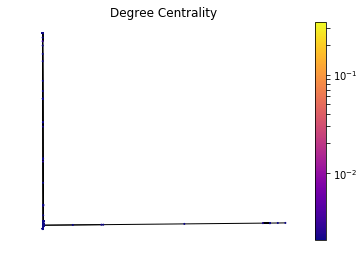

In [100]:
draw(G2, pos, nx.degree_centrality(G2), 'Degree Centrality')

In [87]:
# with open('pos_dict_G2', 'wb') as f:
#     pickle.dump(pos, f, protocol=pickle.HIGHEST_PROTOCOL)

In [88]:
# Too computationally intensive

# nx.draw_networkx(G2, with_labels = False)
# plt.show()

In [89]:
# sorted_degree_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)
# print([x[0] for x in sorted_degree_nodes])
# print([x[1] for x in sorted_degree_nodes])
# print([x for x in sorted_degree_nodes])

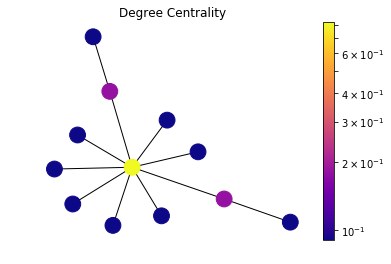

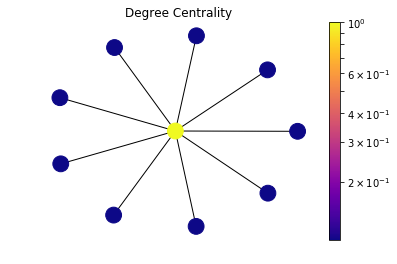

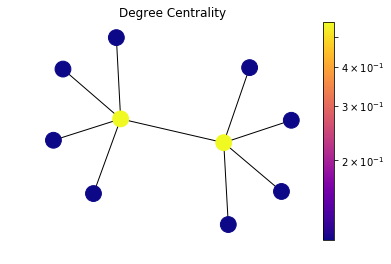

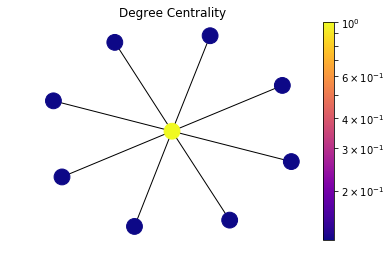

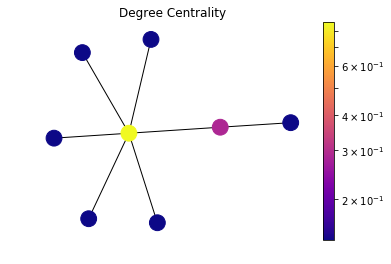

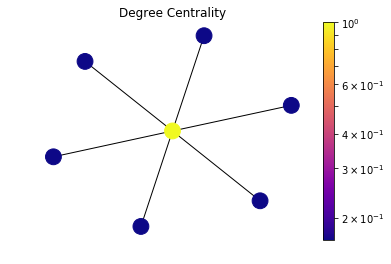

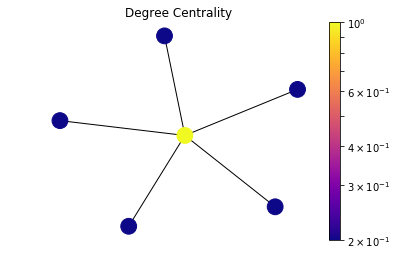

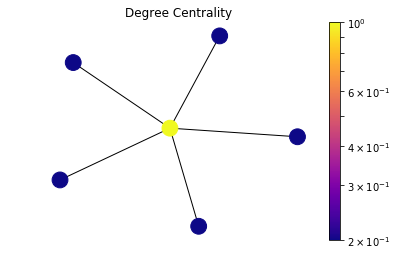

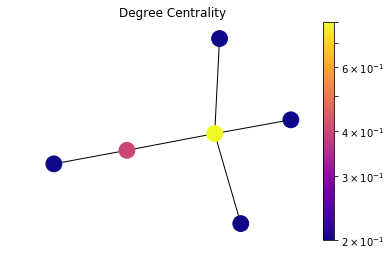

In [91]:
connected_comps = [c for c in sorted(nx.connected_components(G), key=len, reverse=True)]

for c in connected_comps[1:10]:
    G3 = G.subgraph(c)
    plt.figure()
#     nx.draw(G3, pos=nx.spring_layout(G3), with_labels=True) 
#     print(len(G3))
#     print(G3)
    pos = nx.spring_layout(G3)
    draw(G3, pos, nx.degree_centrality(G3), 'Degree Centrality')
#     print([x[0] for x in sorted(G3.degree, key=lambda x: x[1], reverse=True)])